In [47]:
import sys 
from extraction.extract import *
import math
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime
sys.path.append(".")

DATA PREPARATION

In [4]:
# print(dataset.dtypes)
# print(len(dataset.columns))

In [49]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



dataset = generateNNdata("EGLL", timeslotLength=15, catagoricalFlightDuration=False)
dataset = dataset.set_index("timeslot")

# dataset.columns = [
#     "departing",
#     "arriving",
#     "lowcost",
#     "arrivalsFlightDuration",
#     "departuresFlightDuration",
#     "planes",
#     "weekend",
#     "winter",
#     "spring",
#     "summer",
#     "autumn",
#     "night",
#     "morning",
#     "afternoon",
#     "evening",
# 	# "arrivalsArrivalDelay",
# 	"departuresDepartureDelay"
# ]

x = 'arrivals delays'
dataset.drop(columns=['departuresArrivalDelay','arrivalsArrivalDelay'])
if x == 'departures delays':

	label = dataset.pop('departuresDepartureDelay')
	dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label)

elif x == 'arrivals delays':
	label = dataset.pop('arrivalsArrivalDelay')
	dataset.insert(len(dataset.columns), 'arrivalsArrivalDelay', label)

display(dataset)
# Get first month of Data
number_of_months = 7
index_slice = 213*4*24 - 1			#number_of_months * 4 * 24 * 31 - 1
dataset = dataset.iloc[0:index_slice]

# summarize first 5 rows
display(dataset)

# Normalize values
values = dataset.values
display(values)

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# display(scaled)

# frame as supervised learning
number_of_time_steps = 1
number_of_outputs = 1
reframed = series_to_supervised(scaled, n_in=number_of_time_steps, n_out=number_of_outputs)
# drop columns we don't want to predict
reframed.drop(columns=reframed.columns[[i for i in range(20,39)]], inplace=True)  # I don't think we need this, but not sure
display(reframed)

Generating NN data for EGLL with a timeslot length of 15 minutes
Generating EGLL airport data from 2018-01-01 00:00:00 to 2019-12-31 00:00:00


100%|██████████| 7/7 [01:41<00:00, 14.54s/it]


,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,departuresFlightDuration,departuresDepartureDelay,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,arrivalsArrivalDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,1,0,0.0,0.0,0.0,402.0,24.0,62.0,-1,0.011364,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:15:00,1,0,0.0,0.0,0.0,388.0,-20.0,-25.0,-1,0.011364,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:30:00,1,0,0.0,0.0,0.0,260.0,-4.0,-7.0,-1,0.011364,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:45:00,1,1,0.0,53.0,-4.0,249.0,10.0,36.0,0,0.022727,0,0,1,0,0,1,0,0,0,-14.0
2018-03-01 01:00:00,1,0,0.0,0.0,0.0,408.0,-14.0,-24.0,-1,0.011364,0,0,1,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01 10:45:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,0,0,1,0,1,0,0,0.0
2019-10-01 11:00:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,0,0,1,0,1,0,0,0.0
2019-10-01 11:15:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,0,0,1,0,1,0,0,0.0


,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,departuresFlightDuration,departuresDepartureDelay,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,arrivalsArrivalDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,1,0,0.0,0.0,0.0,402.0,24.0,62.0,-1,0.011364,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:15:00,1,0,0.0,0.0,0.0,388.0,-20.0,-25.0,-1,0.011364,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:30:00,1,0,0.0,0.0,0.0,260.0,-4.0,-7.0,-1,0.011364,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:45:00,1,1,0.0,53.0,-4.0,249.0,10.0,36.0,0,0.022727,0,0,1,0,0,1,0,0,0,-14.0
2018-03-01 01:00:00,1,0,0.0,0.0,0.0,408.0,-14.0,-24.0,-1,0.011364,0,0,1,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-29 22:30:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,1,0,0,0,1,0,0,0,1,0.0
2018-09-29 22:45:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,1,0,0,0,1,0,0,0,1,0.0
2018-09-29 23:00:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,1,0,0,0,1,0,0,0,1,0.0


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var20(t)
1,0.05,0.00,0.0,0.000000,0.190476,0.410204,0.576923,0.896907,0.37500,0.030303,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.206186,0.206186
2,0.05,0.00,0.0,0.000000,0.190476,0.395918,0.012821,0.000000,0.37500,0.030303,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.206186,0.206186
3,0.05,0.00,0.0,0.000000,0.190476,0.265306,0.217949,0.185567,0.37500,0.030303,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.206186,0.061856
4,0.05,0.05,0.0,0.052736,0.152381,0.254082,0.397436,0.628866,0.40625,0.060606,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.061856,0.206186
5,0.05,0.00,0.0,0.000000,0.190476,0.416327,0.089744,0.010309,0.37500,0.030303,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.206186,0.206186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20442,0.00,0.00,0.0,0.000000,0.190476,0.000000,0.269231,0.257732,0.40625,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.206186,0.206186
20443,0.00,0.00,0.0,0.000000,0.190476,0.000000,0.269231,0.257732,0.40625,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.206186,0.206186
20444,0.00,0.00,0.0,0.000000,0.190476,0.000000,0.269231,0.257732,0.40625,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.206186,0.206186
20445,0.00,0.00,0.0,0.000000,0.190476,0.000000,0.269231,0.257732,0.40625,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.206186,0.206186


DEFINE AND FIT MODEL

Shape of dataset: (20446, 21)
Shape of train dataset: (14400, 21)
Shape of test dataset: (6046, 21)
Shape of validation dataset: (30, 21)
(14400, 1, 20) (14400,) (6046, 1, 20) (6046,) (30, 1, 20) (30,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                14200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
200/200 [==============================] - 5s 14ms/step - loss: 0.0492 - val_loss: 0.0275
Epoch 2/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0282 - val_loss: 0.0287
Epoch 3/100
200/200 [===================

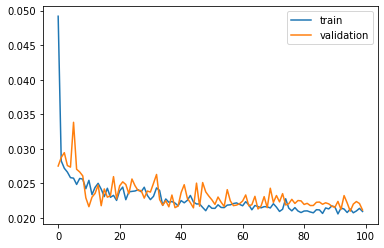

In [56]:
# split into train and test sets
values = reframed.values
number_of_days_to_train = 150
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_days_to_train * 24 * number_of_timeslots_in_one_hour

train = values[:(train_index), :]
#validation = values[(train_index-30):train_index, :]
test = values[train_index:, :]

print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)
print('Shape of validation dataset:', validation.shape)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#val_X, val_y = validation[:, :-1], validation[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], number_of_time_steps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], number_of_time_steps, test_X.shape[1]))
#val_X = val_X.reshape((val_X.shape[0], number_of_time_steps, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data = (test_X, test_y), verbose=1, shuffle=False) #validation_data=(val_X, val_y),
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()




In [57]:
print(test_X.shape)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X.shape)

(6046, 1, 20)
(6046, 20)


In [58]:
print(yhat.shape)

(6046, 1)


In [59]:
test_y = test_y.reshape((len(test_y), 1))


In [60]:
print(test_y.shape)

(6046, 1)


EVALUATE MODEL AND VISUALIZE PREDICTIONS

In [61]:
# make a prediction
#yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
#print(yhat)

inv_yhat = concatenate((yhat, test_X[:, -19:]), axis=1)
#inv_yhat = yhat
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat)

# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -19:]), axis=1)
#inv_y = test_y
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
#print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)


[4.117163 4.117163 4.117163 ... 4.020603 4.020603 4.020603]
[4.123711 4.123711 4.123711 ... 4.123711 4.123711 4.123711]
Test MAE: 0.423


NON SCALED LABELS

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



dataset = generateNNdata("EHAM", timeslotLength=15, catagoricalFlightDuration=False)
dataset = dataset.set_index("timeslot")

# dataset.columns = [
#     "departing",
#     "arriving",
#     "lowcost",
#     "arrivalsFlightDuration",
#     "departuresFlightDuration",
#     "planes",
#     "weekend",
#     "winter",
#     "spring",
#     "summer",
#     "autumn",
#     "night",
#     "morning",
#     "afternoon",
#     "evening",
# 	# "arrivalsArrivalDelay",
# 	"departuresDepartureDelay"
# ]

dataset.drop(columns=['departuresArrivalDelay','arrivalsArrivalDelay'])
label = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label)

# Get first month of Data
number_of_months = 1
index_slice = number_of_months * 4 * 24 * 31 - 1
dataset = dataset.iloc[0:index_slice]

# summarize first 5 rows
display(dataset)

# Normalize values
values = dataset.values
# display(values)
X, y = values[:,:-1], values[:,-1]
display(X)
display(y)
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)
# display(scaled)
scaled = X.concat(y)
# frame as supervised learning
number_of_time_steps = 1
number_of_outputs = 1
reframed = series_to_supervised(scaled, n_in=number_of_time_steps, n_out=number_of_outputs)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)  # I don't think we need this, but not sure
display(reframed)



,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,arrivalsArrivalDelay,departuresFlightDuration,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,departuresDepartureDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:15:00,1,0,1.00,0.0,0.000000,0.0,183.0,15.0,-1,0.01,0,0,1,0,0,1,0,0,0,12.0
2018-03-01 00:30:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:15:00,0,1,1.00,57.0,9.000000,47.0,0.0,0.0,1,0.01,0,0,1,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31 22:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:15:00,1,3,0.75,192.0,-7.333333,-13.0,673.0,16.0,2,0.04,1,0,1,0,0,0,0,0,1,12.0


array([[1.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [1.  , 3.  , 0.75, ..., 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [1.  , 0.  , 1.  , ..., 0.  , 0.  , 1.  ]])

array([12.,  0.,  0., ..., 12.,  0., -7.])

AttributeError: 'numpy.ndarray' object has no attribute 'concat'

In [ ]:
# split into train and test sets
values = reframed.values
number_of_days_to_train = 20
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_days_to_train * 24 * number_of_timeslots_in_one_hour

train = values[:train_index, :]
test = values[train_index:, :]

print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], number_of_time_steps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], number_of_time_steps, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()